In [171]:
import csv
import pandas as pd
import numpy as np

import xgboost as xgb
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.figure
%matplotlib inline

from numpy import sort

from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, classification_report, roc_curve, auc, \
accuracy_score,f1_score, confusion_matrix, precision_recall_curve, roc_auc_score

pd.set_option('display.max_columns', None)

## Preprocessing

In [39]:
#dftrain = pd.read_csv('2020-train.csv')
df = pd.read_csv('2020-train.csv')
df.head(5)

,pitcher_id,pitcher_side,batter_id,batter_side,stadium_id,umpire_id,catcher_id,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,tilt,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,pitch_type,pitch_call,pitch_id
0,d7e3acce,Right,32678d8d,Right,a4833794,f88d09f4,83cdf9ff,3,1,0.0,0,1,93.008102,-1.990750,-0.364950,1995.780029,-150.653000,1:00,5.97789,0.221744,6.45304,-12.477000,18.268900,9.38941,3.05034,0.555689,86.024200,-4.37258,1.429580,0.404622,-0.059343,55,6.03322,FA,InPlay,42fce2f6
1,44ec1bf5,Right,81d51733,Left,f60d6ea5,b67d862c,a126f66f,6,2,0.0,3,2,97.935898,-2.916730,-2.695220,2388.689941,-170.166000,12:15,6.18328,2.123090,6.37298,-10.453700,18.147200,2.89933,2.61284,-0.111897,89.458199,-4.90467,-2.148410,0.385719,-2.148680,55,6.23380,FA,InPlay,3e9cda86
2,44d87ee6,Left,8eefccb7,Right,a9b8b538,13993d26,9db4e46f,5,2,2.0,3,1,81.831398,-1.576020,1.045500,1966.949951,159.830994,11:15,6.12413,-1.294740,6.13114,-23.592199,17.337099,-6.18609,2.63461,-0.937995,75.593597,-6.00728,-0.122044,0.463953,1.300450,55,6.14750,CH,BallCalled,f129a6cd
3,ff6adae0,Right,8f8ab5af,Right,e569ec39,0d8ba4bb,bbbfd290,5,1,2.0,1,2,83.775703,-0.387083,-0.613163,2539.459961,54.268398,7:45,6.58357,1.665380,5.59444,-49.169498,-8.342350,-10.58620,2.17409,0.233674,76.396400,-9.50640,-2.581980,0.458471,-1.659590,55,6.60043,CU,InPlay,03e9bc05
4,c70c96e5,Right,10874746,Right,a5ce1bf6,94a4c552,75087ec8,8,1,2.0,2,1,91.208000,0.140618,-4.035290,2409.110107,246.348999,2:15,4.77355,1.495840,6.12665,-24.760099,8.488800,19.89060,2.84640,-0.703636,83.215302,-4.53233,-0.268188,0.415965,-1.526170,55,4.77332,FA,StrikeCalled,48feb675


In [40]:
df.pitch_call.unique()

array(['InPlay', 'BallCalled', 'StrikeCalled', 'StrikeSwinging',
       'FoulBall', 'HitByPitch', 'BallIntentional'], dtype=object)

In [41]:
# 1 = strike, 0 = ball
df['is_strike'] = np.where(df['pitch_call'].isin (['HitByPitch','BallCalled','BallIntentional']), 0 , 1)

In [42]:
#Checking numerical values
df.describe()

,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,y55,z55,is_strike
count,582205.000000,582205.000000,582053.000000,582205.000000,582205.000000,582093.000000,582093.000000,582093.000000,573194.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582139.000000,582139.000000,582093.000000,582093.000000,582093.000000,582093.000000,582093.000000,582205.0,582093.000000,582205.000000
mean,5.023724,1.490808,0.983716,0.884967,0.892443,88.735005,-1.509087,-1.016170,2220.701818,153.897738,5.919028,0.762446,6.096076,-26.765797,9.066797,1.949702,2.245430,-0.037183,81.262674,-6.522543,-0.643078,0.429799,-0.768401,55.0,5.942944,0.637116
std,2.681336,0.499916,0.817551,0.966970,0.825685,5.921564,1.461114,2.751573,311.995838,103.848721,0.519462,1.984200,0.493010,13.531303,8.884112,10.475652,0.949674,0.864178,5.290006,1.897131,2.237901,0.032315,2.008449,0.0,0.524689,0.480832
min,1.000000,1.000000,0.000000,0.000000,0.000000,41.245602,-10.605200,-16.108700,362.382996,-179.992996,1.005030,-5.687660,0.700274,-227.863007,-189.871994,-46.343201,-5.119020,-15.028200,35.863998,-24.074400,-11.180300,0.355875,-5.072390,55.0,1.076910,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,84.558502,-2.500560,-3.047210,2072.870117,120.449997,5.664400,-1.215270,5.778010,-34.579899,3.966400,-6.534730,1.637880,-0.629551,77.737602,-7.700660,-2.217440,0.405542,-2.221660,55.0,5.687050,0.000000
50%,5.000000,1.000000,1.000000,1.000000,1.000000,90.012398,-1.653390,-1.891370,2238.464966,180.587006,5.958050,1.552420,6.102000,-23.218300,10.983300,3.107390,2.252280,-0.041740,82.390404,-6.276010,-0.774538,0.421253,-1.567670,55.0,5.983480,1.000000
75%,7.000000,2.000000,2.000000,2.000000,2.000000,93.298500,-0.683607,1.282620,2400.800049,219.509995,6.242790,2.199700,6.420880,-15.906800,16.140699,11.009900,2.862650,0.553494,85.246597,-5.151290,0.778672,0.449331,1.235960,55.0,6.268300,1.000000
max,18.000000,2.000000,3.000000,4.000000,2.000000,105.052002,17.904499,9.358300,3752.239990,359.997986,9.790240,4.984060,10.070200,97.565002,132.962006,165.606003,18.021900,12.040800,96.798401,16.200701,10.663700,1.008390,6.626940,55.0,10.153300,1.000000


In [43]:
df['spin_axis'] = [i + 360 if i <0 else i for i in df['spin_axis'] ]

In [44]:
# Remove 'outs = 3' values, 'balls = 4 values' 
df = df[df['outs']!=3]
df = df[df['balls']!=4]

In [45]:
df.drop(columns=['pitch_call', 'y55','pitch_id','tilt'], inplace=True)

In [46]:
df.dropna(inplace=True)

In [47]:
df.describe()

,inning,top_bottom,outs,balls,strikes,release_speed,vert_release_angle,horz_release_angle,spin_rate,spin_axis,rel_height,rel_side,extension,vert_break,induced_vert_break,horz_break,plate_height,plate_side,zone_speed,vert_approach_angle,horz_approach_angle,zone_time,x55,z55,is_strike
count,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000,572559.000000
mean,5.013256,1.490660,0.982676,0.886069,0.889934,88.821367,-1.521606,-1.010861,2220.695491,181.445096,5.920253,0.754257,6.099852,-26.572598,9.182281,2.032107,2.251175,-0.033489,81.336207,-6.499616,-0.622297,0.429343,-0.760246,5.944341,0.637204
std,2.680503,0.499913,0.817275,0.967933,0.825243,5.905825,1.458618,2.762369,311.983006,66.124223,0.518618,1.987514,0.493233,13.520539,8.883922,10.503266,0.947512,0.863233,5.275499,1.895536,2.225939,0.032183,2.011984,0.523869,0.480807
min,1.000000,1.000000,0.000000,0.000000,0.000000,41.396500,-10.605200,-9.101000,362.382996,0.023144,1.005030,-5.518970,1.612180,-171.931000,-68.846298,-32.847698,-3.510870,-6.803380,38.572899,-17.125799,-11.180300,0.355875,-5.072390,1.076910,0.000000
25%,3.000000,1.000000,0.000000,0.000000,0.000000,84.709801,-2.510655,-3.054080,2072.889893,140.304993,5.664830,-1.248255,5.782250,-34.084600,4.249525,-6.499120,1.644600,-0.625770,77.863800,-7.660855,-2.182160,0.405324,-2.219820,5.687590,0.000000
50%,5.000000,1.000000,1.000000,1.000000,1.000000,90.134598,-1.667090,-1.895990,2238.449951,195.792999,5.959000,1.549070,6.106370,-22.902599,11.163500,3.289880,2.257730,-0.037885,82.486298,-6.245150,-0.750310,0.420635,-1.564710,5.984630,1.000000
75%,7.000000,2.000000,2.000000,2.000000,2.000000,93.346603,-0.701327,1.324795,2400.800049,225.141998,6.243585,2.197855,6.424590,-15.831200,16.199800,11.102500,2.866980,0.557038,85.287697,-5.134375,0.790218,0.448506,1.268165,6.269290,1.000000
max,18.000000,2.000000,2.000000,3.000000,2.000000,105.052002,15.231100,9.358300,3752.239990,359.997986,8.750060,4.984060,10.070200,97.565002,132.962006,51.857899,18.021900,12.040800,96.798401,16.200701,9.884520,1.008390,5.582150,9.209940,1.000000


In [48]:
572559/582205

0.9834319526627219

In [ ]:
## Feature Selection

In [67]:
dfnum = df.loc[:,'outs':'z55']
dfin = df.loc[:,'inning']

In [68]:
dfptb = pd.get_dummies(df['top_bottom'], prefix='top_bottom')
dfptype = pd.get_dummies(df['pitch_type'], prefix='pitch_type')
dfpside = pd.get_dummies(df['pitcher_side'], prefix='pitcher_side')
dfbside = pd.get_dummies(df['batter_side'], prefix='batter_side')
dfptype = pd.get_dummies(df['pitch_type'], prefix='pitch_type')
dfpit = pd.get_dummies(df['pitcher_id'], prefix='pitcher_id')
dfbat = pd.get_dummies(df['batter_id'], prefix='batter_id')
dfcatch = pd.get_dummies(df['catcher_id'], prefix='catcher_id')
dfump = pd.get_dummies(df['umpire_id'], prefix='umpire_id')
dfstad = pd.get_dummies(df['stadium_id'], prefix='stadium_id')

In [71]:
dfm = pd.concat([dfnum, dfin, dfptb, dfptype, dfpside, dfbside, dfptype, dfpit, dfbat, dfcatch, \
                dfump,dfstad], axis=1, sort=False)

In [74]:
X = dfm
y = df['is_strike']

In [75]:
X.shape, y.shape

((572559, 2094), (572559,))

In [65]:
print ('Pitcher ids: {}'.format (df['pitcher_id'].nunique()))
print ('Stadium ids: {}'.format (df['stadium_id'].nunique()))
print ('Catcher ids: {}'.format (df['catcher_id'].nunique()))
print ('Umpire ids: {}'.format (df['umpire_id'].nunique()))
print ('Batter ids: {}'.format (df['batter_id'].nunique()))

Pitcher ids: 799
Stadium ids: 48
Catcher ids: 119
Umpire ids: 90
Batter ids: 993


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)

In [77]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)

In [79]:
table = list(zip(X,randomforest.feature_importances_))
dftable = pd.DataFrame(table, columns=['pitch_type','Coef'])
dftable.sort_values(by='Coef', ascending=False)

,pitch_type,Coef
15,plate_side,0.143895
14,plate_height,0.120646
4,vert_release_angle,0.054761
17,vert_approach_angle,0.050045
5,horz_release_angle,0.039438
18,horz_approach_angle,0.038223
9,rel_side,0.021631
20,x55,0.020793
11,vert_break,0.020040
8,rel_height,0.019778


In [133]:
sort(randomforest.feature_importances_)[-45:-35]

array([0.00083913, 0.0008877 , 0.00089652, 0.00094139, 0.00097221,
       0.00099465, 0.00100262, 0.00100268, 0.00101475, 0.00102399])

In [49]:
df['is_strike'].value_counts()

1    364837
0    207722
Name: is_strike, dtype: int64

In [134]:
# make predictions for test data and evaluate
y_pred = randomforest.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("AccuracyF1: %.2f%%" % (f1 * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(randomforest.feature_importances_)[-45:-35]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(randomforest, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	f1 = f1_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	print("Thresh=%.3f, n=%d, f1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))


Accuracy: 83.52%
AccuracyF1: 87.14%
Thresh=0.001, n=45, Accuracy: 85.24%
Thresh=0.001, n=45, f1: 88.23%
Thresh=0.001, n=44, Accuracy: 85.34%
Thresh=0.001, n=44, f1: 88.31%
Thresh=0.001, n=43, Accuracy: 85.22%
Thresh=0.001, n=43, f1: 88.21%
Thresh=0.001, n=42, Accuracy: 85.17%
Thresh=0.001, n=42, f1: 88.17%
Thresh=0.001, n=41, Accuracy: 85.28%
Thresh=0.001, n=41, f1: 88.26%
Thresh=0.001, n=40, Accuracy: 85.30%
Thresh=0.001, n=40, f1: 88.28%
Thresh=0.001, n=39, Accuracy: 85.34%
Thresh=0.001, n=39, f1: 88.31%
Thresh=0.001, n=38, Accuracy: 85.32%
Thresh=0.001, n=38, f1: 88.29%
Thresh=0.001, n=37, Accuracy: 85.35%
Thresh=0.001, n=37, f1: 88.31%
Thresh=0.001, n=36, Accuracy: 85.19%
Thresh=0.001, n=36, f1: 88.17%


In [135]:
thresholds = sort(randomforest.feature_importances_)[-35:-30]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(randomforest, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	f1 = f1_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	print("Thresh=%.3f, n=%d, f1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))


Thresh=0.001, n=35, Accuracy: 85.32%
Thresh=0.001, n=35, f1: 88.27%
Thresh=0.001, n=34, Accuracy: 85.28%
Thresh=0.001, n=34, f1: 88.25%
Thresh=0.001, n=33, Accuracy: 85.29%
Thresh=0.001, n=33, f1: 88.27%
Thresh=0.001, n=32, Accuracy: 85.29%
Thresh=0.001, n=32, f1: 88.26%
Thresh=0.001, n=31, Accuracy: 85.34%
Thresh=0.001, n=31, f1: 88.30%


In [136]:
thresholds = sort(randomforest.feature_importances_)[-30:-25]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(randomforest, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	f1 = f1_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	print("Thresh=%.3f, n=%d, f1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))

Thresh=0.001, n=30, Accuracy: 85.38%
Thresh=0.001, n=30, f1: 88.33%
Thresh=0.001, n=29, Accuracy: 85.43%
Thresh=0.001, n=29, f1: 88.36%
Thresh=0.001, n=28, Accuracy: 85.47%
Thresh=0.001, n=28, f1: 88.39%
Thresh=0.002, n=27, Accuracy: 85.33%
Thresh=0.002, n=27, f1: 88.28%
Thresh=0.002, n=26, Accuracy: 85.45%
Thresh=0.002, n=26, f1: 88.37%


In [138]:
thresholds = sort(randomforest.feature_importances_)[-25:-20]
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(randomforest, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = RandomForestClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	f1 = f1_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
	print("Thresh=%.3f, n=%d, f1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))

Thresh=0.003, n=25, Accuracy: 85.34%
Thresh=0.003, n=25, f1: 88.29%
Thresh=0.003, n=24, Accuracy: 85.14%
Thresh=0.003, n=24, f1: 88.13%
Thresh=0.006, n=23, Accuracy: 85.36%
Thresh=0.006, n=23, f1: 88.29%
Thresh=0.007, n=22, Accuracy: 85.42%
Thresh=0.007, n=22, f1: 88.35%
Thresh=0.010, n=21, Accuracy: 84.75%
Thresh=0.010, n=21, f1: 87.81%


In [143]:
# Defining new dataframe
dfm = pd.concat([dfnum, dfin], axis=1, sort=False)

In [145]:
# Setting new training and testing sets with new features
X = dfm
y = df['is_strike']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

### Baseline

In [152]:
# Guessing all balls pitched are strikes
y_pred = y_test*0+1

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.7796061045272401
Accuracy: 0.6388151460108984


### Logistic Regression

In [159]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.7881365232660228
Accuracy: 0.66283009640911


### Random Forest

In [155]:
randomforest = RandomForestClassifier()
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.8825424721734036
Accuracy: 0.8529237110521168


### Optimized Random Forest:  NOT RUN DUE TO TIME

In [ ]:
randomforest = RandomForestClassifier()
param_grid={'n_estimators': [5, 10, 20, 50, 100], 'max_depth': [10, 20, 30, 50, 100, 200]}
#scores = ['f1']

rfg = GridSearchCV(randomforest, param_grid=param_grid, scoring='f1', cv =10)
rfg.fit(X_train, y_train)
y_pred = rfg.predict(X_test)

print("Best parameters set found on development set:")
print()
print(rfg.best_params_)
print()
print("Grid scores on development set:")
print()
means = rfg.cv_results_['mean_test_score']
stds = rfg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rfg.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('F1 Score:', f1(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

### Gradient Boosting

In [151]:
gbt = GradientBoostingClassifier()
gbt.fit(X_train, y_train)
y_pred = gbt.predict(X_test)

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

F1 Score: 0.8934923796032057
Accuracy: 0.8640928461645941


### Optimized Gradient Boosting: NOT RUN DUE TO TIME

In [ ]:
gradient = GradientBoostingClassifier()
param_grid = {'n_estimators': [800,1000]}

gbtg = GridSearchCV(gradient, param_grid=param_grid, scoring = 'f1', cv =10)
gbtg.fit(X_train, y_train)
y_pred = gbtg.predict(X_test)

print("Best parameters set found on development set:")
print()
print(gbtg.best_params_)
print()
print("Grid scores on development set:")
print()
means = gbtg.cv_results_['mean_test_score']
stds = gbtg.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gbtg.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))

print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test,y_pred))

<Figure size 432x288 with 0 Axes>

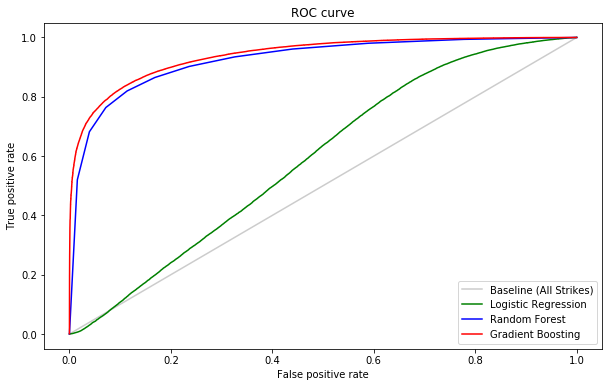

In [169]:
y_pred_lr = lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

y_pred_rf = randomforest.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

y_pred_gbt = gbt.predict_proba(X_test)[:, 1]
fpr_gbt, tpr_gbt, _ = roc_curve(y_test, y_pred_gbt)

y_pred_guess = y_test*0+1
fpr_guess, tpr_guess, _ = roc_curve(y_test, y_pred_guess)

plt.figure(1)
plt.figure(figsize=[10,6])

plt.plot(fpr_guess, tpr_guess, label='Baseline (All Strikes)',c='.8')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression',c='g')
plt.plot(fpr_rf, tpr_rf, label='Random Forest',c='b')
plt.plot(fpr_gbt, tpr_gbt, label='Gradient Boosting',c='r')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [175]:
print ('AUC scores')
print ('Logistic Regression: {}'.format(round(roc_auc_score(y_test, y_pred_lr),3)))
print ('Random Forest: {}'.format(round(roc_auc_score(y_test, y_pred_rf),3)))
print ('Gradient Boosting: {}'.format(round(roc_auc_score(y_test, y_pred_gbt),3)))

AUC scores
Logistic Regression: 0.592
Random Forest: 0.924
Gradient Boosting: 0.94


## Running Model on Test Data

In [177]:
df = pd.read_csv('2020-test.csv')

FileNotFoundError: File b'2020-test.csv' does not exist